In [1]:
from IPython.display import Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image

In [2]:
output_dir = '../output'

In [3]:
def read_file(filename):
	string = open(filename, "r").read()
	string_list = string.split("\n")
	string_list = [line for line in string_list if line and line[0] != '#'] #Read line only if it is nonempty and not a comment.
	return string_list

In [4]:
details_dict = {}
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(output_dir) for f in filenames if "details.csv" in f]
for file in files:
    if 'sample' in file.split('/')[2]:
        sample_id = file.split('/')[2].split('_')[1]
        details_dict[sample_id] = {}
        with open(file, 'r') as f:
            for line in f:
                if line[0].isdigit():
                    line = line.split("\t")
                    contig = line[0].split("_")[0]
                    gd = float(line[1])
                    rd = int(line[2])
                    gc = float(line[3])
                    length = int(line[4])
                    if contig not in details_dict[sample_id]:
                        details_dict[sample_id][contig] = {}
                        details_dict[sample_id][contig]['density'] = gd
                        details_dict[sample_id][contig]['read_depth'] = rd
                        details_dict[sample_id][contig]['GC_cont'] = gc
                        details_dict[sample_id][contig]['length'] = length
                    else:
                        details_dict[sample_id][contig]['read_depth'] += 1                

In [5]:
def update_dict(line, stat_dict, file, folder_loc):
    stat = line.split(" ")[-1]
    stat_dict[file.split('/')[folder_loc]].append(float(stat))
    return stat_dict

def get_output_details(output_dir,tool):
    files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(output_dir) for f in filenames if tool+"_eval.csv" in f]
    precs, recs, f1s = defaultdict(list), defaultdict(list), defaultdict(list)
    prec_ratio, rec_ratio, f1_ratio = defaultdict(list), defaultdict(list), defaultdict(list)

    for file in files:
        if 'sample' in file.split('/')[2]:
            sample_id = file.split('/')[2].split('_')[1]
            if int(sample_id) <= 60:
                ratio = file.split('/')[3]
                with open(file, 'r') as f:
                    for line in f:
                        if "precision" in line:
                            precs = update_dict(line, precs, file, 2)
                            prec_ratio = update_dict(line, prec_ratio, file, 3)
                        if "recall" in line:
                            recs = update_dict(line, recs, file, 2)
                            rec_ratio = update_dict(line, rec_ratio, file, 3)
                        if "f1" in line:
                            f1s = update_dict(line, f1s, file, 2)
                            f1_ratio = update_dict(line, f1_ratio, file, 3)
    return precs, recs, f1s, prec_ratio, rec_ratio, f1_ratio 

In [6]:
def compute_mean(mean, k, precs, recs, f1s):
    mean[k] = {}
    mean[k]['precision'] = sum(precs[k])/len(precs[k])
    mean[k]['recall'] = sum(recs[k])/len(recs[k])
    mean[k]['f1_score'] = sum(f1s[k])/len(f1s[k])
    return mean

def compute_max(best, k, precs, recs, f1s):
    best[k] = {}
    best[k]['precision'] = max(precs[k])
    best[k]['recall'] = max(recs[k])
    best[k]['f1_score'] = max(f1s[k])
    return best

def get_mean(precs, recs, f1s):
    mean, best = {}, {}
    mean_scores, best_scores = [], [] 
    for sample_id in precs:
        mean[sample_id] = {}
        mean[sample_id]['precision'] = sum(precs[sample_id])/len(precs[sample_id])
        mean[sample_id]['recall'] = sum(recs[sample_id])/len(recs[sample_id])
        mean[sample_id]['f1_score'] = sum(f1s[sample_id])/len(f1s[sample_id])
        mean_scores.append([sample_id, mean[sample_id]['precision'], mean[sample_id]['recall'], mean[sample_id]['f1_score']])

        best[sample_id] = {}
        best[sample_id]['precision'] = max(precs[sample_id])
        best[sample_id]['recall'] = max(recs[sample_id])
        best[sample_id]['f1_score'] = max(f1s[sample_id])  
        best_scores.append([sample_id, best[sample_id]['precision'], best[sample_id]['recall'], best[sample_id]['f1_score']])

    mean_scores = pd.DataFrame(mean_scores)
    mean_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

    best_scores = pd.DataFrame(best_scores)
    best_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)
    return mean, best, mean_scores, best_scores

In [7]:
precs, recs, f1s = defaultdict(list), defaultdict(list), defaultdict(list)
prec_ratio, rec_ratio, f1_ratio = defaultdict(list), defaultdict(list), defaultdict(list)

precs, recs, f1s, prec_ratio, rec_ratio, f1_ratio = get_output_details(output_dir,"MILP")

In [8]:
greedy_precs, greedy_recs, greedy_f1s = defaultdict(list), defaultdict(list), defaultdict(list)
greedy_prec_ratio, greedy_rec_ratio, greedy_f1_ratio = defaultdict(list), defaultdict(list), defaultdict(list)

greedy_precs, greedy_recs, greedy_f1s, greedy_prec_ratio, greedy_rec_ratio, greedy_f1_ratio = get_output_details(output_dir,"greedy")

In [9]:
mean, best = {}, {}
mean_scores, best_scores = [], [] 

mean, best, mean_scores, best_scores = get_mean(precs, recs, f1s)

In [10]:
greedy_mean, greedy_best = {}, {}
greedy_mean_scores, greedy_best_scores = [], [] 

greedy_mean, greedy_best, greedy_mean_scores, greedy_best_scores = get_mean(greedy_precs, greedy_recs, greedy_f1s)

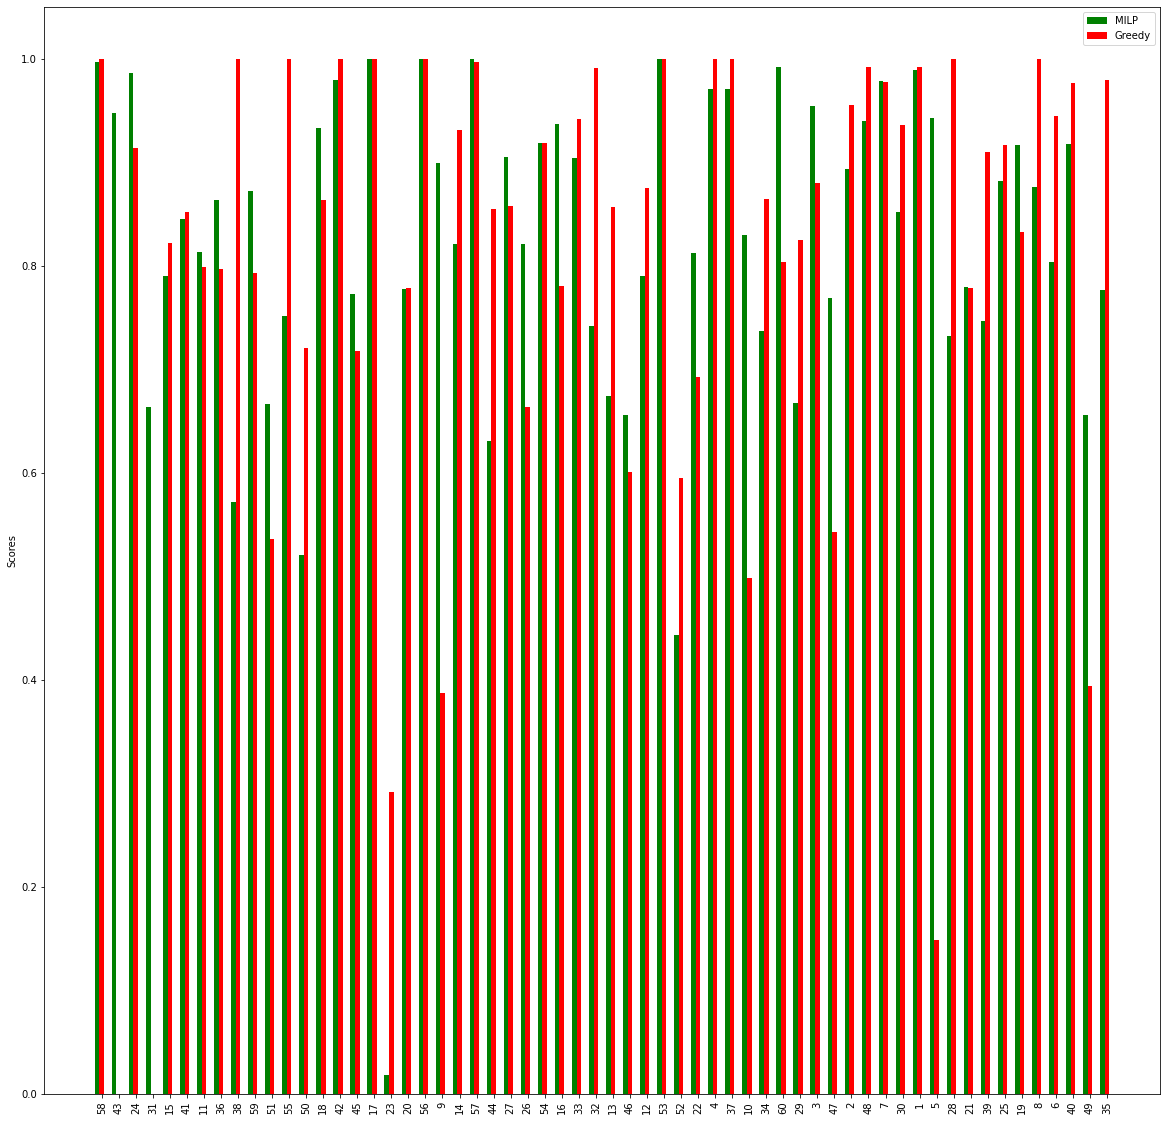

In [11]:
N = 60
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(20,20))

axp = fig.add_subplot(111)

ids = mean_scores['Sample'].values.tolist()
ids = [k.split('_')[1] for k in ids]

pvals = mean_scores['Precision'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='g')
gpvals = greedy_mean_scores['Precision'].values.tolist()
rects3 = axp.bar(ind+width, gpvals, width, color='r')
axp.set_ylabel('Scores')
axp.set_xticks(ind+width)
axp.set_xticklabels([(ids[i]) for i in range(len(ids))])
axp.legend( (rects1[0], rects3[0]), ('MILP', 'Greedy') )
plt.xticks(rotation=90)
plt.show()

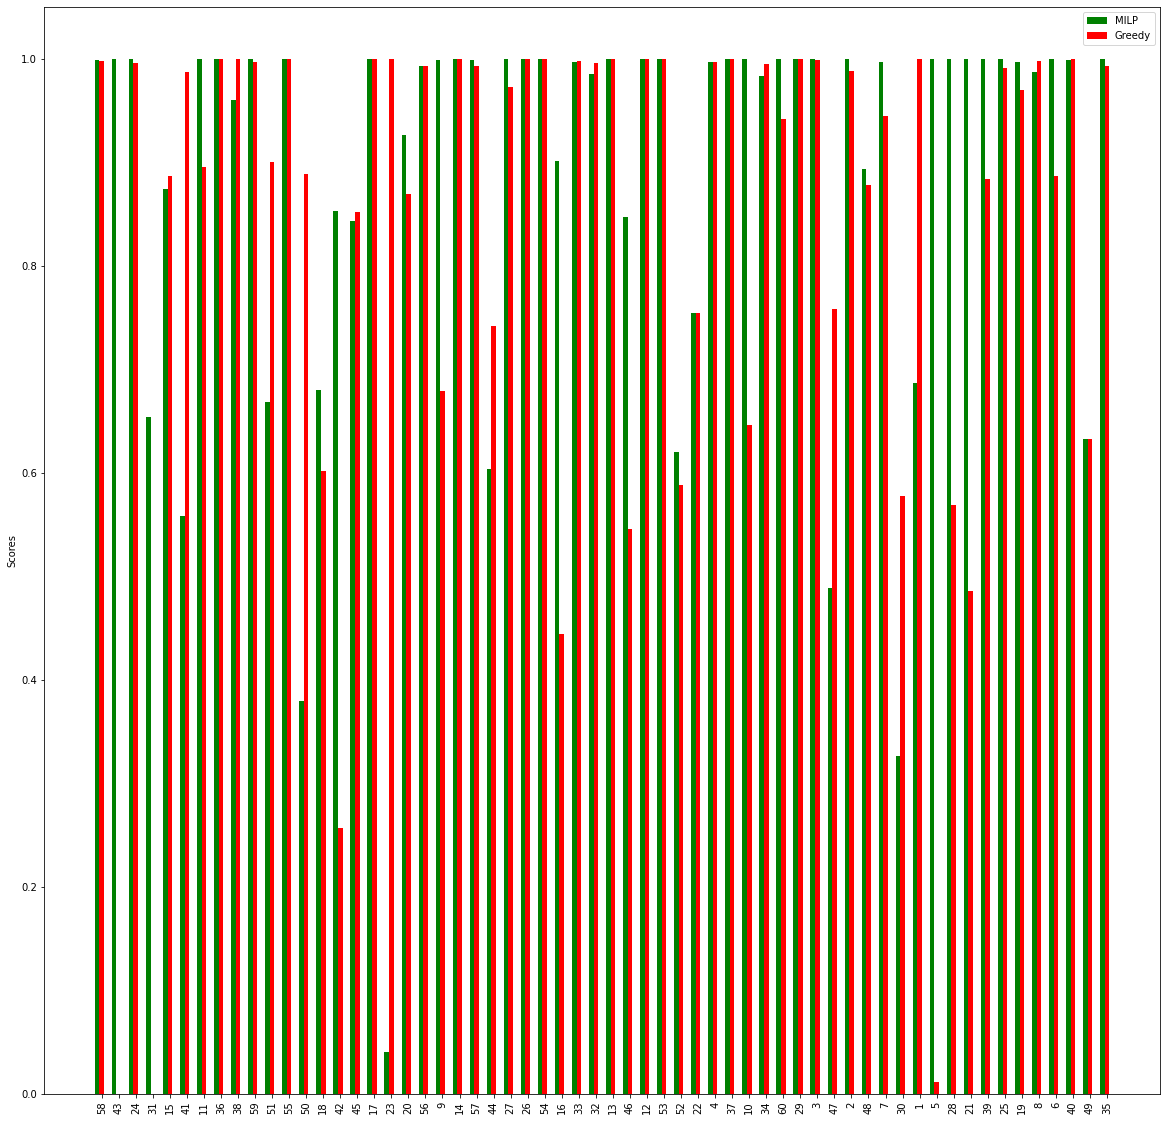

In [12]:
N = 60
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(20,20))

axp = fig.add_subplot(111)

ids = mean_scores['Sample'].values.tolist()
ids = [k.split('_')[1] for k in ids]

rvals = mean_scores['Recall'].values.tolist()
rects1 = axp.bar(ind, rvals, width, color='g')
grvals = greedy_mean_scores['Recall'].values.tolist()
rects3 = axp.bar(ind+width, grvals, width, color='r')
axp.set_ylabel('Scores')
axp.set_xticks(ind+width)
axp.set_xticklabels([(ids[i]) for i in range(len(ids))])
axp.legend( (rects1[0], rects3[0]), ('MILP', 'Greedy') )
plt.xticks(rotation=90)
plt.show()

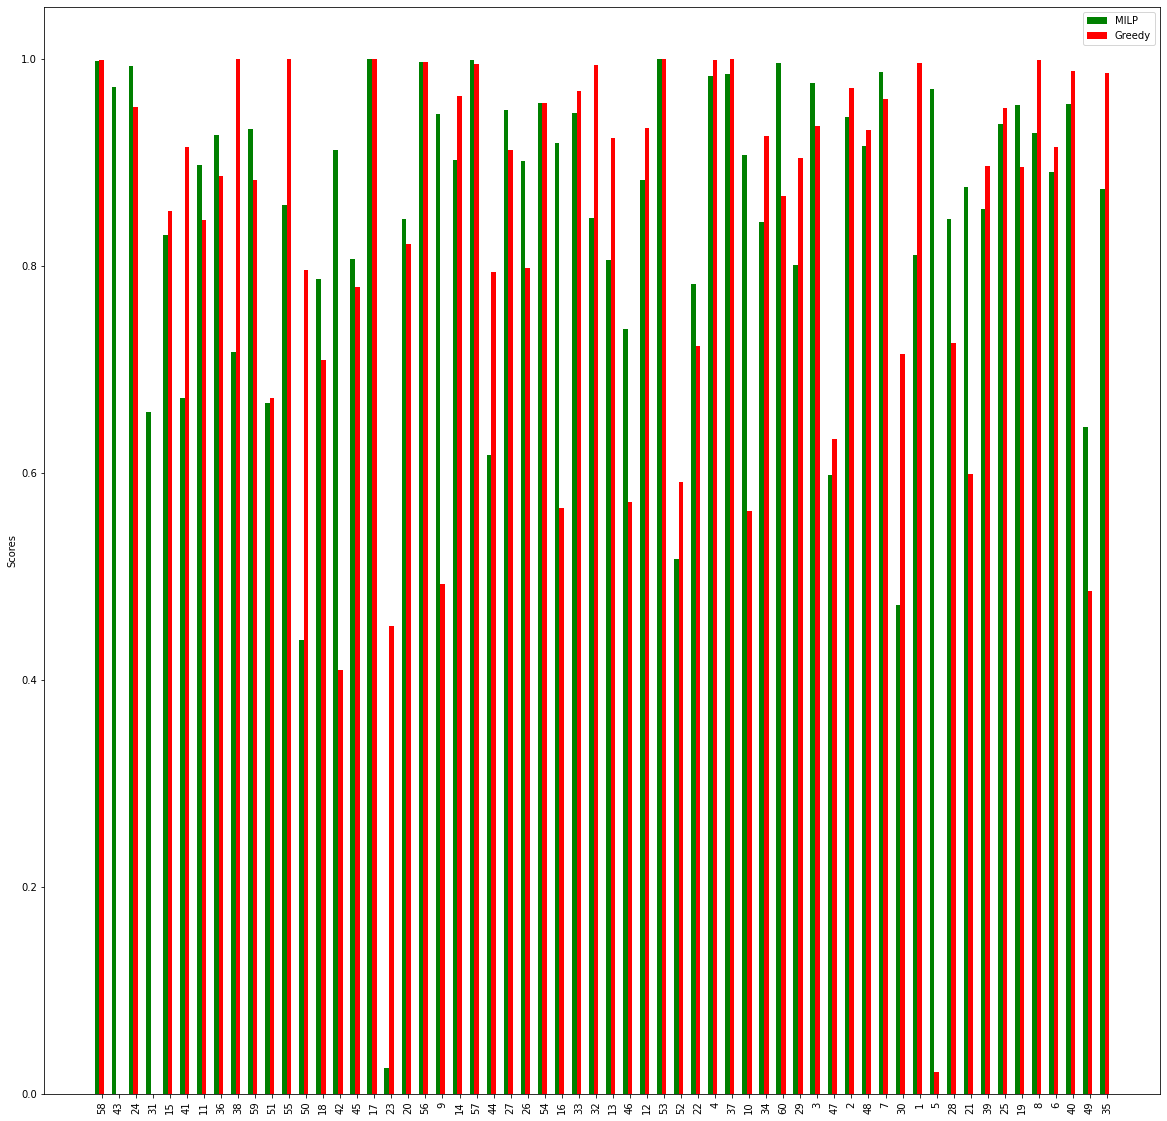

In [13]:
N = 60
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(20,20))

axp = fig.add_subplot(111)

ids = mean_scores['Sample'].values.tolist()
ids = [k.split('_')[1] for k in ids]

fvals = mean_scores['F1 score'].values.tolist()
rects1 = axp.bar(ind, fvals, width, color='g')
gfvals = greedy_mean_scores['F1 score'].values.tolist()
rects3 = axp.bar(ind+width, gfvals, width, color='r')
axp.set_ylabel('Scores')
axp.set_xticks(ind+width)
axp.set_xticklabels([(ids[i]) for i in range(len(ids))])
axp.legend( (rects1[0], rects3[0]), ('MILP', 'Greedy') )
plt.xticks(rotation=90)
plt.show()

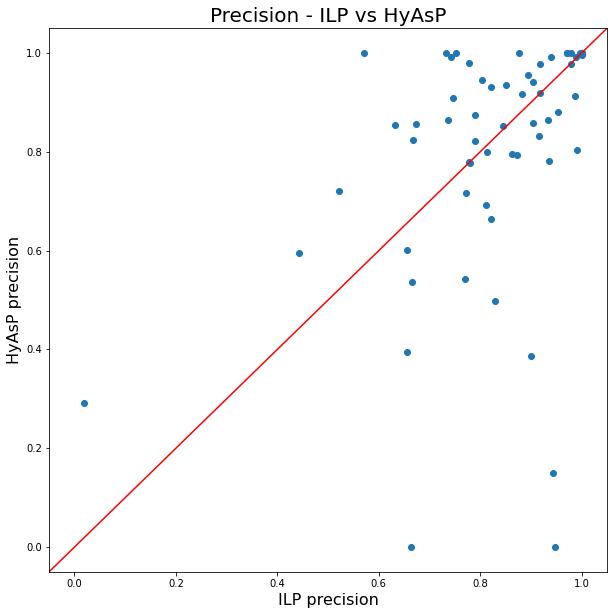

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ids)
samples = mean_scores['Sample'].values.tolist()
#groups = GC_DF['BP'].groupby("SAMPLE")
#for name, group in groups:
pvals = mean_scores['Precision'].values.tolist()
gpvals = greedy_mean_scores['Precision'].values.tolist()
plt.scatter(pvals, gpvals)
plt.axline([0, 0], [1, 1], color = 'r')
#plt.legend(loc=[1.01,0.3])
plt.title("Precision - ILP vs HyAsP", fontsize=20)
plt.xlabel('ILP precision', fontsize=16)
plt.ylabel('HyAsP precision', fontsize=16)
plt.show()

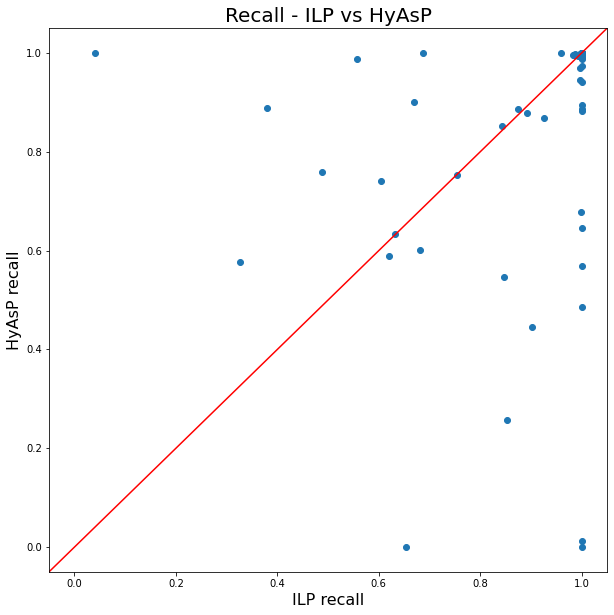

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ids)
samples = mean_scores['Sample'].values.tolist()
#groups = GC_DF['BP'].groupby("SAMPLE")
#for name, group in groups:
rvals = mean_scores['Recall'].values.tolist()
grvals = greedy_mean_scores['Recall'].values.tolist()
plt.scatter(rvals, grvals)
plt.axline([0, 0], [1, 1], color = 'r')
#plt.legend(loc=[1.01,0.3])
plt.title("Recall - ILP vs HyAsP", fontsize=20)
plt.xlabel('ILP recall', fontsize=16)
plt.ylabel('HyAsP recall', fontsize=16)
plt.show()

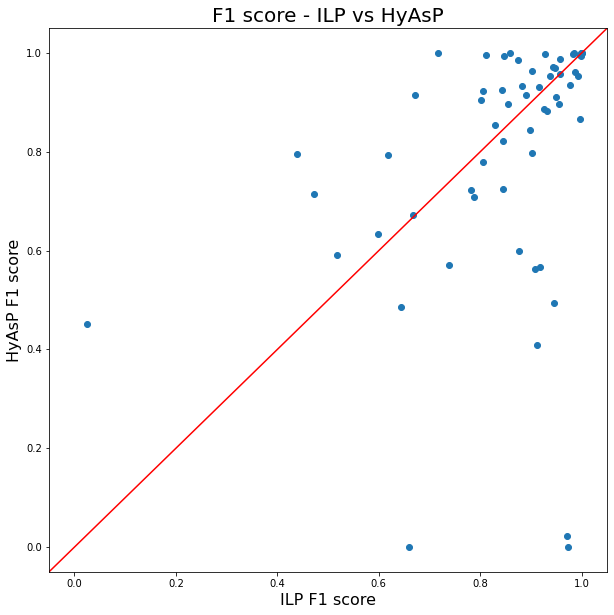

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ids)
samples = mean_scores['Sample'].values.tolist()
#groups = GC_DF['BP'].groupby("SAMPLE")
#for name, group in groups:
fvals = mean_scores['F1 score'].values.tolist()
gfvals = greedy_mean_scores['F1 score'].values.tolist()
plt.scatter(fvals, gfvals)
plt.axline([0, 0], [1, 1], color = 'r')
#plt.legend(loc=[1.01,0.3])
plt.title("F1 score - ILP vs HyAsP", fontsize=20)
plt.xlabel('ILP F1 score', fontsize=16)
plt.ylabel('HyAsP F1 score', fontsize=16)
plt.show()

## Visualization -line graphs maybe